In [1]:
import os
import numpy as np
import ipywidgets as widgets
from glmtools.io.glm import GLMDataset
from datetime import datetime, timedelta

In [2]:
from glmtools.test.common import get_sample_data_path

sample_path = get_sample_data_path()
samples = [
    "OR_GLM-L2-LCFA_G16_s20181830433000_e20181830433200_c20181830433231.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433200_e20181830433400_c20181830433424.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433400_e20181830434000_c20181830434029.nc",
]
samples = [os.path.join(sample_path, s) for s in samples]

## Create and plot grids of the sample data included in glmtools

The command below creates grids on the ABI fixed grid at 2 km. The `cmd` is an ordinary shell command - you can run it in a terminal or as part of a shell script.

The domain is a GOES mesoscale sector centered on the provided lon/lat. It is not necessary to provide the center if using the conus or full disk domains.

The start and end times will be inferred from the data files if not provided, and in this case would result in a grid with a single 1-min frame.

Here, we create a 5 min grid. This grid will be empty except for the minute (0433 UTC) corresponding to the data.

In [3]:
import subprocess
import os, glob
import tempfile
tmpdir = tempfile.TemporaryDirectory()

import glmtools
from glmtools.test.common import get_sample_data_path
glmtools_path = os.path.abspath(glmtools.__path__[0])

# Set the start time and duration
startdate = datetime(2018, 7, 2, 4, 30)
duration = timedelta(0, 60*5)
enddate = startdate+duration
    
cmd = "python {0}/../examples/grid/make_GLM_grids.py -o {1}"
cmd += " --fixed_grid --split_events --goes_position=east --goes_sector=meso"
cmd += " --ctr_lat=33.5 --ctr_lon=-101.5 --dx=2.0 --dy=2.0"
cmd += " --start={3} --end={4} {2}"

cmd = cmd.format(glmtools_path, tmpdir.name, ' '.join(samples),
                startdate.isoformat(), enddate.isoformat())
# print (cmd)
out_bytes = subprocess.check_output(cmd.split())
# print(out_bytes.decode('utf-8'))

grid_dir_base = tmpdir.name
nc_files = glob.glob(os.path.join(grid_dir_base, startdate.strftime('%Y/%b/%d'),'*.nc'))
# print(nc_files)

**Run the cell below to see the log file created by the gridding process.**

In [4]:
%%bash
# cat make_GLM_grid.log

## Grab and load the files for each grid type

In [5]:
from lmatools.grid.grid_collection import LMAgridFileCollection

# 056 is 2 km resolution
res = '056'

dtdx_base = '{0}_1src_{1}urad-dx'.format(int(duration.total_seconds()), res)
glm_init_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_flash_init.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_fed_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_flash_extent.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_ed_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_source.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_energy_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_total_energy.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_foot_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_footprint.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_grinit_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_init.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_ged_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_extent.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_grfoot_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_area.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))


display_params = {}
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm, Normalize
glm_cmap = get_cmap('viridis')
glm_cmap._init()
alphas = np.linspace(1.0, 1.0, glm_cmap.N+3)
glm_cmap._lut[:,-1] = alphas
glm_cmap._lut[0,-1] = 0.0

glm_flctr_grids = LMAgridFileCollection(glm_init_files, 'flash_centroid_density',
                                        x_name='x', y_name='y', t_name='time')
display_params[glm_flctr_grids] = {
    'product_label':"GLM Flash Centroid Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=5),
    'file_tag':'flash_init'
}

glm_fed_grids = LMAgridFileCollection(glm_fed_files, 'flash_extent_density',
                                      x_name='x', y_name='y', t_name='time')
display_params[glm_fed_grids] = {
    'product_label':"GLM Flash Extent Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=20),
    'file_tag':'flash_extent',
}

glm_ged_grids = LMAgridFileCollection(glm_ged_files, 'group_extent_density',
                                      x_name='x', y_name='y', t_name='time')
display_params[glm_ged_grids] = {
    'product_label':"GLM Group Extent Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=200),
    'file_tag':'group_extent',
}

glm_ed_grids = LMAgridFileCollection(glm_ed_files, 'event_density',
                                     x_name='x', y_name='y', t_name='time')
display_params[glm_ed_grids] = {
    'product_label':"GLM Event Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=200),
    'file_tag':'event_density',
}

glm_energy_grids = LMAgridFileCollection(glm_energy_files, 'total_energy',
                                         x_name='x', y_name='y', t_name='time')
display_params[glm_energy_grids] = {
    'product_label':"GLM Total Energy (J)",
    'glm_norm':LogNorm(vmin=1e-18, vmax=1e-12),
    'file_tag':'total_energy'
}
# display_params[glm_energy_grids]['glm_cmap'].set_bad('w',0)

glm_flarea_grids = LMAgridFileCollection(glm_foot_files, 'average_flash_area', x_name='x', y_name='y', t_name='time')
display_params[glm_flarea_grids] = {
    'product_label':"GLM Average Flash Area (km^2)",
    'glm_norm':Normalize(vmin=0, vmax=.5e4),
    'file_tag':'flash_area'
}

glm_grarea_grids = LMAgridFileCollection(glm_grfoot_files, 'average_group_area', x_name='x', y_name='y', t_name='time')
display_params[glm_grarea_grids] = {
    'product_label':"GLM Average Group Area (km^2)",
    'glm_norm':Normalize(vmin=0, vmax=.5e4),
    'file_tag':'group_area'
}

## Make an interactive plot with a map background

In [6]:
# Plot this grid
glm_grids = glm_fed_grids

# Grab the needed paramters for plotting
glm_norm = display_params[glm_grids]['glm_norm']
product_label = display_params[glm_grids]['product_label']
file_tag = display_params[glm_grids]['file_tag']

<IPython.core.display.Javascript object>


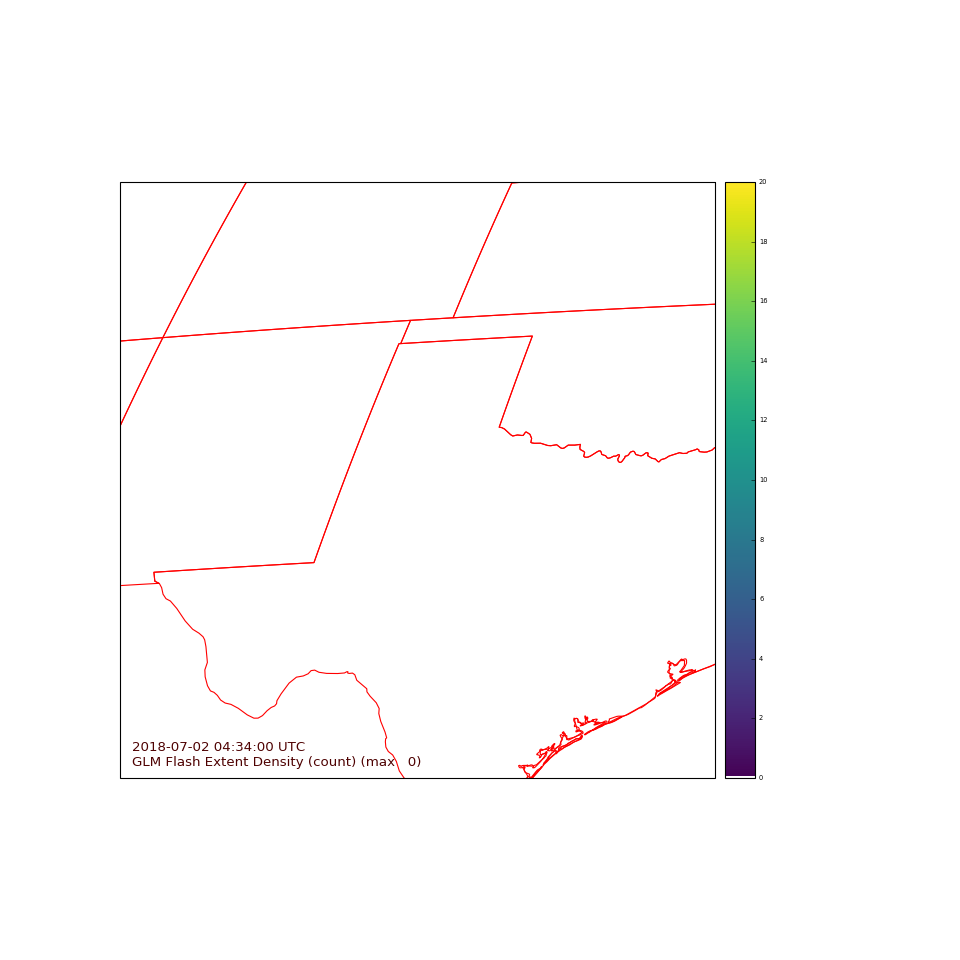

In [7]:
label_string = """
{1} (max {0:3.0f})"""

%matplotlib notebook
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

glm_times = glm_grids.times
glm_times.sort()

geoproj = ccrs.Geodetic()
    
def plot(t, fig):
    
    fig.clf()
    t_glm = t['new']
    glmx, glmy, glm, glm_nc= glm_grids.data_for_time(t_glm, return_nc=True)
    proj_var = glm_nc.variables['goes_imager_projection']
    x = glmx * proj_var.perspective_point_height
    y = glmy * proj_var.perspective_point_height
    
    glm_xlim = x.min(), x.max()
    glm_ylim = y.min(), y.max()

#     Use a masked array instead of messing with colormap to get transparency
#     glm = np.ma.array(glm, mask=(glm == 0))
#     glm_alpha = .5 + glm_norm(glm)*0.5

    state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                    name='admin_1_states_provinces_lakes',
                                                    scale='50m', facecolor='none')
    globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
    proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                              satellite_height=proj_var.perspective_point_height, globe=globe)
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    glm_img = ax.imshow(glm, extent=(x.min(), x.max(), 
                           y.min(), y.max()), 
#                            transform = ccrs.PlateCarree(),
                           cmap=glm_cmap, interpolation='nearest',
                           norm=glm_norm)#, alpha=0.8)
    ax.coastlines('10m', color='red')
    ax.add_feature(state_boundaries, edgecolor='red')
    
    # Match the GLM grid limits, in fixed grid space
    ax.set_xlim(glm_xlim)
    ax.set_ylim(glm_ylim)

    # Set a lat/lon box directly
#     ax.set_extent([-103, -99.5, 31.0, 34.0])
    
    limits = ax.axis()
    ax.text(limits[0]+.02*(limits[1]-limits[0]), limits[2]+.02*(limits[3]-limits[2]), 
        t_glm.isoformat().replace('T', ' ')+' UTC'+
        label_string.format(glm.max(), product_label), 
#             transform = proj,
        color=(0.3, 0.0, 0.0))


    cbar = plt.colorbar(glm_img, orientation='vertical')
    # Make the colorbar position match the height of the Cartopy axes
    # Have to draw to force layout so that the ax position is correct
    fig.canvas.draw()
    posn = ax.get_position()
    cbar.ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])



fig = plt.figure(figsize=(12,12))

def resize_colorbar(event):
    ax, cbar_ax = fig.axes[0], fig.axes[1]
    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])
fig.canvas.mpl_connect('resize_event', resize_colorbar)

from functools import partial
plot = partial(plot, fig=fig)
    
from ipywidgets import widgets
time_slider = widgets.SelectionSlider(options=glm_times)
time_slider.observe(plot, 'value')
display(time_slider)
time_slider.value = time_slider.options[3]

# Save an image of each frame

The code below loops through the slider positions and saves a figure at each step.
The cell below that displays one of those images.

In [8]:
# print(grid_dir_base)
# print(file_tag)
images_out = []
for option in time_slider.options[:]:
    time_slider.value = option
    resize_colorbar('foo')
    outfile=grid_dir_base + 'GLM_{1}_{0}.png'.format(option, file_tag)
    outfile = outfile.replace(' ', '_')
    outfile = outfile.replace(':', '')
    images_out.append(outfile)
    fig.savefig(outfile)
# print(images_out)

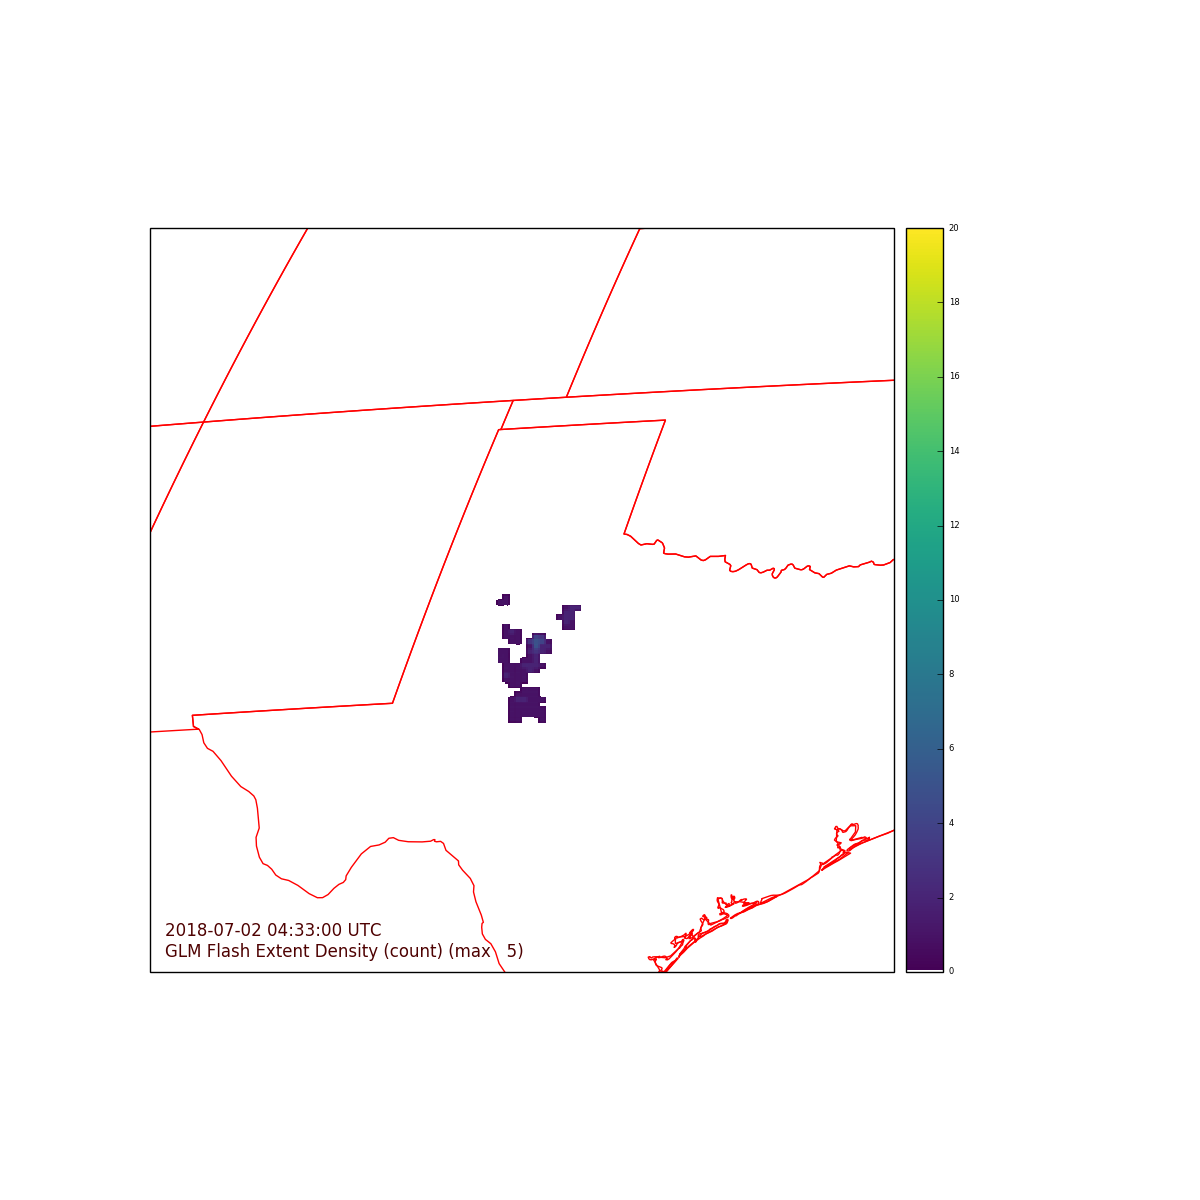

In [9]:
from IPython.display import Image
Image(images_out[3])